# Replication Project: Final Dataframe

**Replication Game – Berlin, 30 October 2025 Berlin**  

---

**Institut for Replication & Freie Universität Berlin**  

**Author:** [Dominik Bursy](mailto:dominik.bursy@icloud.com)  

**Last Updated:** October 2025

---

**Reference:**  
Berazneva, Julia, and Tanya S. Byker. 2017. *Does Forest Loss Increase Human Disease? Evidence from Nigeria.* American Economic Review, 107(5), 516–521. https://doi.org/10.1257/aer.p20171132

---

**Resources:**  
- [Guidelines on the Use of DHS GPS Data (English)](https://dhsprogram.com/publications/publication-SAR8-Spatial-Analysis-Reports.cfm)
- [Nigeria - Subnational Administrative Boundaries](https://data.humdata.org/dataset/cod-ab-nga)


**Notes:**  
- EPSG:3857 is a spherical Mercator projected coordinate system in meters, ideal for web mapping applications like Google Maps, while EPSG:4326 is a geographic coordinate system in degrees using the WGS84 ellipsoid, which represents Earth as a 3D sphere and is used by GPS systems.
- To protect the confidentiality of respondents the geo-located data is displaced (Burgert et al., 2013). The displacement process moves the latitude and longitude to a new location under set parameters. Urban locations are displaced 0-2 kilometers while rural locations are displaced 0-5 kilometers with 1% (or every 100th point) displaced 0-10 kilometers.
- Administrative level 2 contains 774 feature(s). The normal administrative level 2 feature type is *Local Governement Area*.
- Berazneva and Byker (2017) did not provide detailed information on how the data were cleaned or subset, such as the exclusion of observations with missing age values.

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

## Save Figures
savefigures = True

/Users/dominikbursy/Documents/8_PhD_New/replication_game


---

## Import Data 

In [160]:
## Import DHS Dataframe being the base structure
gdf_dhs = gpd.read_file(f"{ROOT_FOLDER}/output/gdf_dhs.geojson")

In [161]:
## Import forest loss, luminosity, and soil properties
gdf_dhs = gpd.read_file(f"{ROOT_FOLDER}/output/gdf_dhs.geojson")
df_forest_change = pd.read_csv(f"{ROOT_FOLDER}/output/dataframe_forest_change.csv", index_col=0)
df_luminosity = pd.read_csv(f"{ROOT_FOLDER}/output/dataframe_luminosity.csv", index_col=0)
df_soil = pd.read_csv(f"{ROOT_FOLDER}/output/dataframe_soil_depth_0_15.csv", index_col=0)

In [162]:
## Combine DHS Dataframe with geospatial dataframes
gdf_dhs = gdf_dhs.join(df_forest_change.drop(columns="caseid"))
gdf_dhs = gdf_dhs.join(df_luminosity.drop(columns="caseid"))
gdf_dhs = gdf_dhs.join(df_soil.drop(columns="caseid"))

In [163]:
## Nigeria - Subnational Administrative Boundaries
gdf_nigeria = gpd.read_file(f"{ROOT_FOLDER}/datasets/map_africa/nga_admbnda_adm2_osgof_20190417.shp")

gdf_nigeria = gdf_nigeria.reset_index(names="LGA")
gdf_nigeria_dhs = gdf_nigeria.sjoin(gdf_dhs, how="left")

# Name of LGAs is stored in ADM2_EN

## Plot Geographic Variation of Forest Loss in Nigeria by LGA (2001–2012)

In [164]:
## Subset dataframe by forest loss from 2001 to 2012
summation_columns = list(df_forest_change.drop(columns=["caseid", "forest_loss_2013", "forest_loss_2014", "forest_loss_size", "treecover_mean"]).columns)

## Drop the 2018 wave
condition = gdf_nigeria_dhs["DHSYEAR"] != 2018

## Create mean forest loss from 2001 - 2012 
gdf_nigeria_dhs["forest_loss_sum"] = gdf_nigeria_dhs[summation_columns].sum(axis=1)
gdf_nigeria_dhs["forest_loss_mean"] = gdf_nigeria_dhs["forest_loss_sum"] / gdf_nigeria_dhs["forest_loss_size"]

In [165]:
## Group by LGA to calculate the mean forest loss from 2001 - 2012 by LGA
gdf_forest_loss = (gdf_nigeria_dhs.loc[condition].groupby("LGA")
    .agg({
        "forest_loss_mean": "mean",
        "geometry": "first"   # keep the first geometry
    })
    .reset_index()
)

## Store in dataframe for plotting 
gdf_forest_loss = gpd.GeoDataFrame(gdf_forest_loss, geometry=gdf_forest_loss["geometry"], crs="EPSG:4326")
gdf_forest_loss["forest_loss_mean"] *= 100

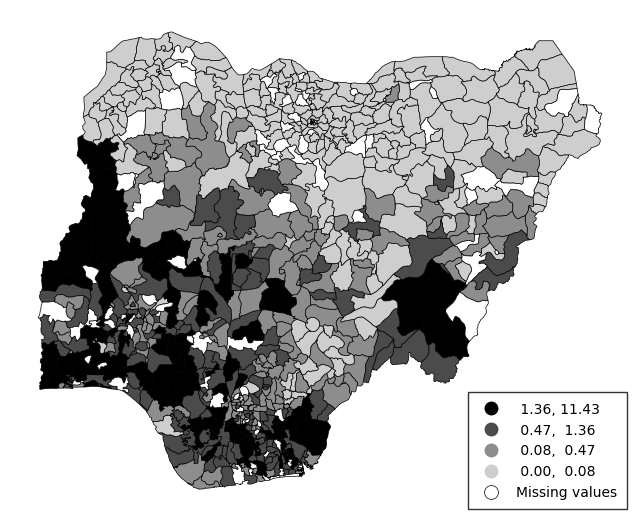

In [166]:
import mapclassify
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

# Truncate Greys so it starts at 0.3 (skip very light values) → goes from mid-gray to black
cmap = plt.colormaps.get_cmap("Greys")  # full colormap
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "trunc_greys", cmap(np.linspace(0.3, 1, 256))  # start at 0.3 → skip lightest tones
)

bins = [0, 0.076, 0.4675, 1.361, ]

fig, ax = plt.subplots(figsize=(8, 8))

gdf_nigeria.join(
    gdf_forest_loss.drop(columns="geometry").set_index("LGA")
    ).plot(
    column="forest_loss_mean",
    cmap=new_cmap,
    scheme="UserDefined",
    classification_kwds={"bins": bins[1:]},
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    missing_kwds={"color": "white", "label": "Missing values"}, # "edgecolor": "white", "hatch": "///"
    ax=ax
)

# condition = gdf_dhs["DHSYEAR"] != 2018
# gpd.sjoin(
#     gdf_dhs[condition], gdf_nigeria, 
#     how="inner", predicate="within"
# ).drop_duplicates("geometry").plot(ax=ax,
#     color="maroon",     # pick a contrasting color (red shows up well on Greyscale)
#     markersize=5,   # adjust point size (default ~36, so 10 is smaller)
#     alpha=1,       # slightly transparent for better blending
#     edgecolor="none", linewidth=0.3  # thin black outline
# )

# condition = gdf_dhs["DHSYEAR"] == 2018
# gpd.sjoin(
#     gdf_dhs[condition], gdf_nigeria, 
#     how="inner", predicate="within"
# ).drop_duplicates("geometry").plot(ax=ax,
#     color="orange",     # pick a contrasting color (red shows up well on Greyscale)
#     markersize=5,   # adjust point size (default ~36, so 10 is smaller)
#     alpha=1,       # slightly transparent for better blending
#     edgecolor="none", linewidth=0.3  # thin black outline
# )

# --- Fix legend order (reverse bins, keep missing last) ---
leg = ax.get_legend()
if leg is not None:
    handles, labels = leg.legend_handles, [t.get_text() for t in leg.get_texts()]
    
    # Split out "Missing values"
    new_handles, new_labels = [], []
    missing_handle, missing_label = None, None
    
    for h, l in zip(handles, labels):
        if "Missing" in l:  # detect missing
            missing_handle, missing_label = h, l
        else:
            new_handles.append(h)
            new_labels.append(l)
    
    # Reverse numeric bins
    new_handles = new_handles[::-1]
    new_labels = new_labels[::-1]
    
    # Add missing last (if it exists)
    if missing_handle is not None:
        new_handles.append(missing_handle)
        new_labels.append(missing_label)
    
    # Rebuild legend
    leg.remove()
    ax.legend(
        new_handles,
        new_labels,
        #title="forest_loss_mean",
        loc="lower right"
    )

# Get legend
leg = ax.get_legend()
if leg is not None:
    frame = leg.get_frame()
    frame.set_edgecolor("black")  # black border
    frame.set_linewidth(1)      # thicker line
    frame.set_boxstyle("square")  # sharp corners (instead of rounded)


ax.set_axis_off()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/figures/Berazneva_Byker_Figure_1.png', bbox_inches='tight')
else:
    plt.tight_layout()


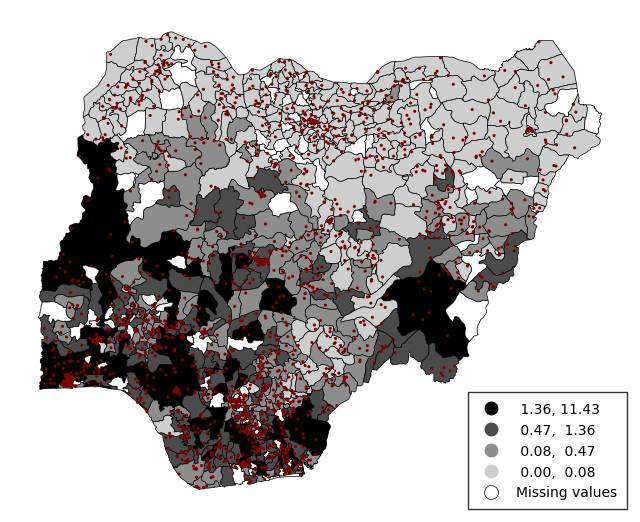

In [167]:
import mapclassify
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

# Truncate Greys so it starts at 0.3 (skip very light values) → goes from mid-gray to black
cmap = plt.colormaps.get_cmap("Greys")  # full colormap
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "trunc_greys", cmap(np.linspace(0.3, 1, 256))  # start at 0.3 → skip lightest tones
)

bins = [0, 0.076, 0.4675, 1.361, ]

fig, ax = plt.subplots(figsize=(8, 8))

gdf_nigeria.join(
    gdf_forest_loss.drop(columns="geometry").set_index("LGA")
    ).plot(
    column="forest_loss_mean",
    cmap=new_cmap,
    scheme="UserDefined",
    classification_kwds={"bins": bins[1:]},
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    missing_kwds={"color": "white", "label": "Missing values"}, # "edgecolor": "white", "hatch": "///"
    ax=ax
)

condition = gdf_dhs["DHSYEAR"] != 2018
gpd.sjoin(
    gdf_dhs[condition], gdf_nigeria, 
    how="inner", predicate="within"
).drop_duplicates("geometry").plot(ax=ax,
    color="maroon",     # pick a contrasting color (red shows up well on Greyscale)
    markersize=5,   # adjust point size (default ~36, so 10 is smaller)
    alpha=1,       # slightly transparent for better blending
    edgecolor="none", linewidth=0.3  # thin black outline
)

# --- Fix legend order (reverse bins, keep missing last) ---
leg = ax.get_legend()
if leg is not None:
    handles, labels = leg.legend_handles, [t.get_text() for t in leg.get_texts()]
    
    # Split out "Missing values"
    new_handles, new_labels = [], []
    missing_handle, missing_label = None, None
    
    for h, l in zip(handles, labels):
        if "Missing" in l:  # detect missing
            missing_handle, missing_label = h, l
        else:
            new_handles.append(h)
            new_labels.append(l)
    
    # Reverse numeric bins
    new_handles = new_handles[::-1]
    new_labels = new_labels[::-1]
    
    # Add missing last (if it exists)
    if missing_handle is not None:
        new_handles.append(missing_handle)
        new_labels.append(missing_label)
    
    # Rebuild legend
    leg.remove()
    ax.legend(
        new_handles,
        new_labels,
        #title="forest_loss_mean",
        loc="lower right"
    )

# Get legend
leg = ax.get_legend()
if leg is not None:
    frame = leg.get_frame()
    frame.set_edgecolor("black")  # black border
    frame.set_linewidth(1)      # thicker line
    frame.set_boxstyle("square")  # sharp corners (instead of rounded)


ax.set_axis_off()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/figures/Berazneva_Byker_Figure_1_Points.png', bbox_inches='tight')
else:
    plt.tight_layout()


## Calculate mean forest loss, luminosity, and soil properties per LGA

In [144]:
# Take all yearly loss columns (exclude caseid and forest_loss_size)
loss_years = df_forest_change.drop(columns=["caseid", "forest_loss_size", "treecover_mean"]).columns

# Normalize each by forest_loss_size
gdf_nigeria_dhs[loss_years] = gdf_nigeria_dhs[loss_years].div(
    gdf_nigeria_dhs["forest_loss_size"], axis=0
)

In [145]:
## Forest Change per LGA

condition = gdf_nigeria_dhs["DHSYEAR"] == 2008

gdf_nigeria_dhs.loc[condition, [
    "loss_2001_pt_2008MEAN", "loss_2002_pt_2008MEAN",
    "loss_2003_pt_2008MEAN", "loss_2004_pt_2008MEAN",
    "loss_2005_pt_2008MEAN", "loss_2006_pt_2008MEAN",
    "loss_2007_pt_2008MEAN", "loss_2008_pt_2008MEAN",
    "loss_2009_pt_2008MEAN", "loss_2010_pt_2008MEAN",
    "loss_2011_pt_2008MEAN", "loss_2012_pt_2008MEAN",
    "loss_2013_pt_2008MEAN", "loss_2014_pt_2008MEAN",
    "treecover_2008MEAN"]] = (gdf_nigeria_dhs.loc[condition].groupby("LGA")[list(df_forest_change.drop(columns=["caseid", "forest_loss_size"]).columns)]
    .transform("mean").values
)

## Forest Change per LGA

condition = gdf_nigeria_dhs["DHSYEAR"] == 2013

gdf_nigeria_dhs.loc[condition, [
    "loss_2001_pt_2013MEAN", "loss_2002_pt_2013MEAN",
    "loss_2003_pt_2013MEAN", "loss_2004_pt_2013MEAN",
    "loss_2005_pt_2013MEAN", "loss_2006_pt_2013MEAN",
    "loss_2007_pt_2013MEAN", "loss_2008_pt_2013MEAN",
    "loss_2009_pt_2013MEAN", "loss_2010_pt_2013MEAN",
    "loss_2011_pt_2013MEAN", "loss_2012_pt_2013MEAN",
    "loss_2013_pt_2013MEAN", "loss_2014_pt_2013MEAN",
    "treecover_2013MEAN"]] = (gdf_nigeria_dhs.loc[condition].groupby("LGA")[list(df_forest_change.drop(columns=["caseid", "forest_loss_size"]).columns)]
    .transform("mean").values
)

## Forest Change per LGA

condition = gdf_nigeria_dhs["DHSYEAR"] == 2018

gdf_nigeria_dhs.loc[condition, [
    "loss_2001_pt_2018MEAN", "loss_2002_pt_2018MEAN",
    "loss_2003_pt_2018MEAN", "loss_2004_pt_2018MEAN",
    "loss_2005_pt_2018MEAN", "loss_2006_pt_2018MEAN",
    "loss_2007_pt_2018MEAN", "loss_2008_pt_2018MEAN",
    "loss_2009_pt_2018MEAN", "loss_2010_pt_2018MEAN",
    "loss_2011_pt_2018MEAN", "loss_2012_pt_2018MEAN",
    "loss_2013_pt_2018MEAN", "loss_2014_pt_2018MEAN",
    "treecover_2018MEAN"]] = (gdf_nigeria_dhs.loc[condition].groupby("LGA")[list(df_forest_change.drop(columns=["caseid", "forest_loss_size"]).columns)]
    .transform("mean").values
)

In [146]:
## Luminosity per LGA

condition = gdf_nigeria_dhs["DHSYEAR"] == 2008

gdf_nigeria_dhs.loc[condition, ["f162005_cluster_2008MEAN", "f162006_cluster_2008MEAN", "f162007_cluster_2008MEAN", "f162008_cluster_2008MEAN"]] = (
    gdf_nigeria_dhs.loc[condition].groupby("LGA")[["f162005", "f162006", "f162007", "f162008"]]
    .transform("mean").values
)

condition = gdf_nigeria_dhs["DHSYEAR"] == 2013

gdf_nigeria_dhs.loc[condition, ["f182010_cluster_2013MEAN", "f182011_cluster_2013MEAN", "f182012_cluster_2013MEAN", "f182013_cluster_2013MEAN"]] = (
    gdf_nigeria_dhs.loc[condition].groupby("LGA")[["f182010", "f182011", "f182012", "f182013"]]
    .transform("mean").values
)

condition = gdf_nigeria_dhs["DHSYEAR"] == 2018

gdf_nigeria_dhs.loc[condition, ["f162005_cluster_2018MEAN", "f162006_cluster_2018MEAN", "f162007_cluster_2018MEAN", "f162008_cluster_2018MEAN"]] = (
    gdf_nigeria_dhs.loc[condition].groupby("LGA")[["f182010", "f182011", "f182012", "f182013"]]
    .transform("mean").values
)

In [147]:
## Soil characteristics per LGA

gdf_nigeria_dhs[["occ_ave_pt", "ph_ave_pt", "cec_ave_pt"]] = (
    gdf_nigeria_dhs.groupby("LGA")[["soil_ORCDRC", "soil_PHIHOX", "soil_CEC"]]
    .transform("mean").values
)

## Subset by Variables included in Berazneva and Byker (2017)

In [148]:
df_final = pd.read_stata(f"{ROOT_FOLDER}/resources/113539-V1/Data_programs_readme/dta.dta")
final_columns = list(df_final.columns)
final_columns.append("geometry")

In [149]:
dict_dhs_features = {
    "v002": "v002",    # df_dhs_2008_children
    "v003": "v003",    # df_dhs_2008_children
    "v005": "v005",    # df_dhs_2008_children
    "v021": "v021",    # df_dhs_2008_children
    "v022": "v022",    # df_dhs_2008_children
    "v136": "no_HH_members",    # df_dhs_2008_children
    "v137": "no_kids_under_5",    # df_dhs_2008_children
    "v115": "time_to_water",    # df_dhs_2008_children
    "v025": "rural",    # df_dhs_2008_children
    "v152": "head_HH_age",    # df_dhs_2008_children -> Not perfect, but likely picked by the authors 
    "v715": "HH_head_edu_years",    # df_dhs_2008_children
    "v459": "own_bednet",   # df_dhs_2008_children
    "v151": "femhh",    # df_dhs_2008_children -> Likely female household / Sex of household head
    "v116": "toilet",   # df_dhs_2008_children: 31 corresponds to no toilet
    "v460": "kidnet",   # df_dhs_2008_children
    "v190": "poorest",    # df_dhs_2008_children: Wealth index quintile / Alternatively, dhs_2008_household_path: hv270
    "v161": "firewood",    # df_dhs_2008_children: Type of cooking fuel
    "v127": "floor",    # df_dhs_2008_children: "Main floor material of higher quality df_dhs_2008_children.v127.isin([20, 21, 22, 30, 31, 32, 33, 34, 35])
    "v012": "age_resp",     # df_dhs_2008_children
    "v133": "edu_years",     # df_dhs_2008_children
    "v130": "christian",    # df_dhs_2008_children: Religion
    "v130": "muslim",    # df_dhs_2008_children: Religion
    "v131": "yoruba",    # df_dhs_2008_children: Ethnicity
    "v131": "igbo",    # df_dhs_2008_children: Ethnicity
    "v131": "hausa",    # df_dhs_2008_children: Ethnicity
    "v201": "no_child_total",  # df_dhs_2008_children
    "v218": "no_child_living",  # df_dhs_2008_children
    "v461": "resp_slept_net",   # df_dhs_2008_children ???
    "v714": "resp_works",     # df_dhs_2008_children
    "v213": "pregnant",     # df_dhs_2008_children
    "v501": "married",     # df_dhs_2008_children: Marital status
    "v501": "livewith",     # df_dhs_2008_children: Marital status
    "v006": "month",    # df_dhs_2008_children
    "v024": "region",    # df_dhs_2008_children
    "b8": "age",   # df_dhs_2008_children
    "h22": "fever",   # df_dhs_2008_children
    "h11": "diarrhea",   # df_dhs_2008_children
    "h31": "cough",   # df_dhs_2008_children

    # DHS Geographic Data 
    "ALT_DEM": "altitude",   
    "DHSCLUST": "DHSCLUST", ## Duplicate v001
    "DHSYEAR": "DHSYEAR", 
}

## Export Dataframe

In [157]:
gdf_nigeria_dhs.drop(columns=["ADM2ALT1EN", "ADM2ALT2EN", "validTo"]).to_csv(f"{ROOT_FOLDER}/output/replication_full.csv")

## Export Dataframe to Stata

In [150]:
## Calculate the area of LGAs 
gdf_nigeria_dhs["LGA_Area"] = gdf_nigeria_dhs.to_crs(epsg=3857).area * 1e-6

In [151]:
## Export only Variables included in Berazneva and Byker (2017)
condition = gdf_nigeria_dhs["DHSYEAR"] != 2018 
gdf_nigeria_dhs.loc[condition, final_columns].drop(columns="geometry").to_stata(f"{ROOT_FOLDER}/output/dta_replication.dta")

In [ ]:
## Export additional Variables
# condition = gdf_nigeria_dhs["DHSYEAR"] != 2018
# gdf_nigeria_dhs.loc[condition, final_columns + ["treecover_mean"] + ["forest_loss_size"] + ["LGA_Area"]].drop(columns="geometry").to_stata(f"{ROOT_FOLDER}/output/dta_replication_additional.dta")

In [155]:
## Export all Variables including the DHS Wave 2018
gdf_nigeria_dhs.drop(columns=["ADM2ALT1EN", "ADM2ALT2EN", "validTo", "geometry"]).to_stata(f"{ROOT_FOLDER}/output/dta_replication_full.dta")

---